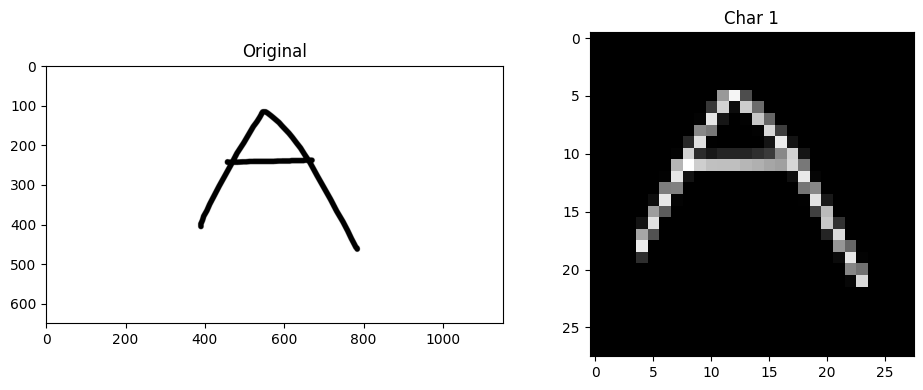

Recognized text: A


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import os



def preprocess_char(img):
    """Preprocess a character image to match EMNIST format"""
    # Convert to grayscale if needed
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Invert if needed (EMNIST has white text on black background)
    if np.mean(img) > 127:
        img = 255 - img
    
    # Apply Otsu's thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find center of mass
    m = cv2.moments(img)
    if m["m00"] != 0:
        cx = int(m["m10"] / m["m00"])
        cy = int(m["m01"] / m["m00"])
    else:
        cx, cy = img.shape[1] // 2, img.shape[0] // 2
    
    # Get bounding box
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        # Crop to bounding box with some margin
        margin = 4
        x_min = max(0, x - margin)
        y_min = max(0, y - margin)
        x_max = min(img.shape[1], x + w + margin)
        y_max = min(img.shape[0], y + h + margin)
        img = img[y_min:y_max, x_min:x_max]
    
    # Resize to 20x20 and pad to 28x28 (EMNIST standard)
    if img.size > 0:
        # Resize to 20x20 while maintaining aspect ratio
        h, w = img.shape
        if h > w:
            new_h, new_w = 20, int(w * 20 / h)
        else:
            new_h, new_w = int(h * 20 / w), 20
        
        if new_h > 0 and new_w > 0:
            img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
        # Pad to 28x28
        h, w = img.shape
        top = (28 - h) // 2
        bottom = 28 - h - top
        left = (28 - w) // 2
        right = 28 - w - left
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    else:
        img = np.zeros((28, 28), dtype=np.uint8)
    
    return img

# 4. Segment characters from an image with multiple characters
def segment_characters(img):
    """Segment characters from an image with handwritten text"""
    # Convert to grayscale if needed
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from left to right
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
    
    char_images = []
    for contour in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out very small contours (noise)
        if w > 5 and h > 5:
            # Extract character
            char_img = thresh[y:y+h, x:x+w]
            # Preprocess character
            processed_char = preprocess_char(char_img)
            char_images.append(processed_char)
    
    return char_images

# 5. Recognize characters and combine into text
def recognize_text(model, char_images):
    """Recognize characters and combine into text"""
    # Map indices to letters (A-Z)
    letters = [chr(i + ord('A')) for i in range(26)]
    
    recognized_text = ""
    for char_img in char_images:
        # Normalize and reshape for model input
        img = char_img.reshape(1, 28, 28, 1).astype('float32') / 255.0
        
        # Predict
        prediction = model.predict(img, verbose=0)
        predicted_class = np.argmax(prediction)
        
        # Convert to character
        if predicted_class < len(letters):
            recognized_text += letters[predicted_class]
    
    return recognized_text

# Main execution
if __name__ == "__main__":
    # Load EMNIST dataset
    
    # Create and train model (or load pre-trained model)
    model_path = 'model.h5'
    model = load_model(model_path)

    
    # Test with a single character image
    def recognize_single_char(img_path):
        img = cv2.imread(img_path)
        processed = preprocess_char(img)
        plt.figure(figsize=(6, 2))
        plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
        plt.subplot(122), plt.imshow(processed, cmap='gray'), plt.title('Processed')
        plt.show()
        
        # Recognize
        processed = processed.reshape(1, 28, 28, 1).astype('float32') / 255.0
        prediction = model.predict(processed, verbose=0)
        predicted_class = np.argmax(prediction)
        letter = chr(predicted_class + ord('A'))
        print(f"Recognized character: {letter}")
    
    # Test with multiple characters
    def recognize_multiple_chars(img_path):
        img = cv2.imread(img_path)
        plt.figure(figsize=(10, 4))
        plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
        
        # Segment characters
        char_images = segment_characters(img)
        
        # Display segmented characters
        plt.subplot(122)
        for i, char_img in enumerate(char_images):
            plt.subplot(1, len(char_images) + 1, i + 2)
            plt.imshow(char_img, cmap='gray')
            plt.title(f'Char {i+1}')
        plt.tight_layout()
        plt.show()
        
        # Recognize text
        text = recognize_text(model, char_images)
        print(f"Recognized text: {text}")

# Example usage:
# recognize_single_char('path_to_single_char.jpg')
recognize_multiple_chars('ale.png')